In [1]:
#!/usr/bin/env python3
"""
Neven Caplar 
Last updated: 2023-10-07

Goals: 
Analyze the data

Each Section can/should be able to run independently,
only these initial imports should be shared among all sections

"""
import numpy as np
import pandas as pd
import time

# from scipy.spatial import KDTree
import matplotlib.pyplot as plt

import JaxPeriodDrwFit


from tape.ensemble import Ensemble
from tape.utils import ColumnMapper

# Tape Single Pixel - real data 

In [12]:
username= "wbeebe"
basedir = f"/astro/users/{username}/data/"

In [19]:
"""
0. Negative log-likelihood of the Gaussian Process model
1. log_drw_scale = theta[0]
2. log_drw_amp = theta[1]
3. log_per_scale = theta[2]
4. log_per_amp = theta[3]
"""

res_tsp_run_0 = pd.read_parquet(f"{basedir}/res_tsp_run_g_0.parquet", engine='pyarrow')
res_tsp_run_0_drw = pd.read_parquet(f"{basedir}/res_tsp_run_g_0_drw.parquet", engine='pyarrow')
# numpy version of the results
res_tsp_run_0_np = np.vstack(res_tsp_run_0.values)
res_tsp_run_0_drw_np = np.vstack(res_tsp_run_0_drw.values)

celerite_run = pd.read_parquet(f"{basedir}/celerite/res_tsp_run_g_0.parquet", engine='pyarrow')
celerite_run_drw = pd.read_parquet(f"{basedir}/celerite/res_tsp_run_g_0_drw.parquet", engine='pyarrow')
# numpy version of the results
celerite_run_np = np.vstack(celerite_run.values)
celerite_run_drw_np = np.vstack(celerite_run_drw.values)

In [14]:
def plot_likelihoods(res, res_drw):
    # larger numbers, bigger relative improvment
    improvment = (res[:,0]-res_drw[:,0])/res_drw[:,0]

    plt.figure(figsize=(16,8))
    plt.subplot(2,3, 1)
    plt.scatter(res[:,1],res[:,2], c=improvment, cmap='jet')
    plt.xlabel('log_drw_scale')
    plt.ylabel('log_drw_amp')
    #plt.axvline(np.log10(drw_tau), ls=':')
    #plt.axhline(np.log10(drw_amp), ls=':')
    plt.xlim(np.quantile(res[:,1],0.05) - .1, np.quantile(res[:,1],0.95) + .1)
    plt.ylim(np.quantile(res[:,2],0.05) - .1, np.quantile(res[:,2],0.95) + .1)


    plt.subplot(2, 3, 2)
    plt.scatter(res[:,1],res[:,3]-np.log10(2*np.pi), c=improvment, cmap='jet')
    plt.xlabel('log_drw_scale')
    plt.ylabel('log_per_scale')
    # plt.axvline(np.log10(drw_tau), ls=':')
    # plt.axhline(np.log10(per_tau), ls=':')
    plt.xlim(np.quantile(res[:,1],0.05)- .1, np.quantile(res[:,1],0.95)+ .1)
    plt.ylim(np.quantile(res[:,3],0.05)-np.log10(2*np.pi) - .1, np.quantile(res[:,3],0.95)-np.log10(2*np.pi)+ .1)

    plt.subplot(2, 3, 3)
    plt.scatter(res[:,1],res[:,4], c=improvment, cmap='jet')
    plt.xlabel('log_drw_scale')
    plt.ylabel('log_per_amp')
    # plt.axvline(np.log10(drw_tau), ls=':')
    # plt.axhline(np.log10(per_amp), ls=':')
    plt.xlim(np.quantile(res[:,1],0.05)- .1, np.quantile(res[:,1],0.95)+ .1)
    plt.ylim(np.quantile(res[:,4],0.05)- .1, np.quantile(res[:,4],0.95)+ .1)

    plt.subplot(2, 3, 4)
    plt.scatter(res[:,2],res[:,3]-np.log10(2*np.pi), c=improvment, cmap='jet')
    plt.xlabel('log_drw_amp')
    plt.ylabel('log_per_scale')
    # plt.axvline(np.log10(drw_amp), ls=':')
    # plt.axhline(np.log10(per_tau), ls=':')
    plt.xlim(np.quantile(res[:,2],0.05)- .1, np.quantile(res[:,2],0.95)+ .1)
    plt.ylim(np.quantile(res[:,3]-np.log10(2*np.pi),0.05)- .1, np.quantile(res[:,3]-np.log10(2*np.pi),0.95)+ .1)

    plt.subplot(2, 3, 5)
    plt.scatter(res[:,2],res[:,4], c=improvment, cmap='jet')
    plt.xlabel('log_drw_amp')
    plt.ylabel('log_per_amp')
    # plt.axvline(np.log10(drw_amp), ls=':')
    # plt.axhline(np.log10(per_amp), ls=':')
    plt.xlim(np.quantile(res[:,2],0.05)- .1, np.quantile(res[:,2],0.95)+ .1)
    plt.ylim(np.quantile(res[:,4],0.05)- .1, np.quantile(res[:,4],0.95)+ .1)

    plt.subplot(2, 3, 6)
    plt.scatter(res[:,3]-np.log10(2*np.pi),res[:,4], c=improvment, cmap='jet')
    plt.xlabel('log_per_scale')
    plt.ylabel('log_per_amp')
    # plt.axhline(np.log10(per_amp), ls=':')
    # plt.axvline(np.log10(per_tau), ls=':')
    plt.xlim(np.quantile(res[:,3],0.05)-np.log10(2*np.pi)- .1, np.quantile(res[:,3],0.95)-np.log10(2*np.pi)+ .1)
    plt.ylim(np.quantile(res[:,4],0.05)- .1, np.quantile(res[:,4],0.95)+ .1) 

In [15]:
def more_plots(res, res_drw):
    plt.figure(figsize=(14,4))
    plt.subplot(121)
    plt.plot(res[:,0])
    plt.plot(res_drw[:,0])

    plt.subplot(122)
    plt.plot((res[:,0]-res_drw[:,0])/res_drw[:,0])

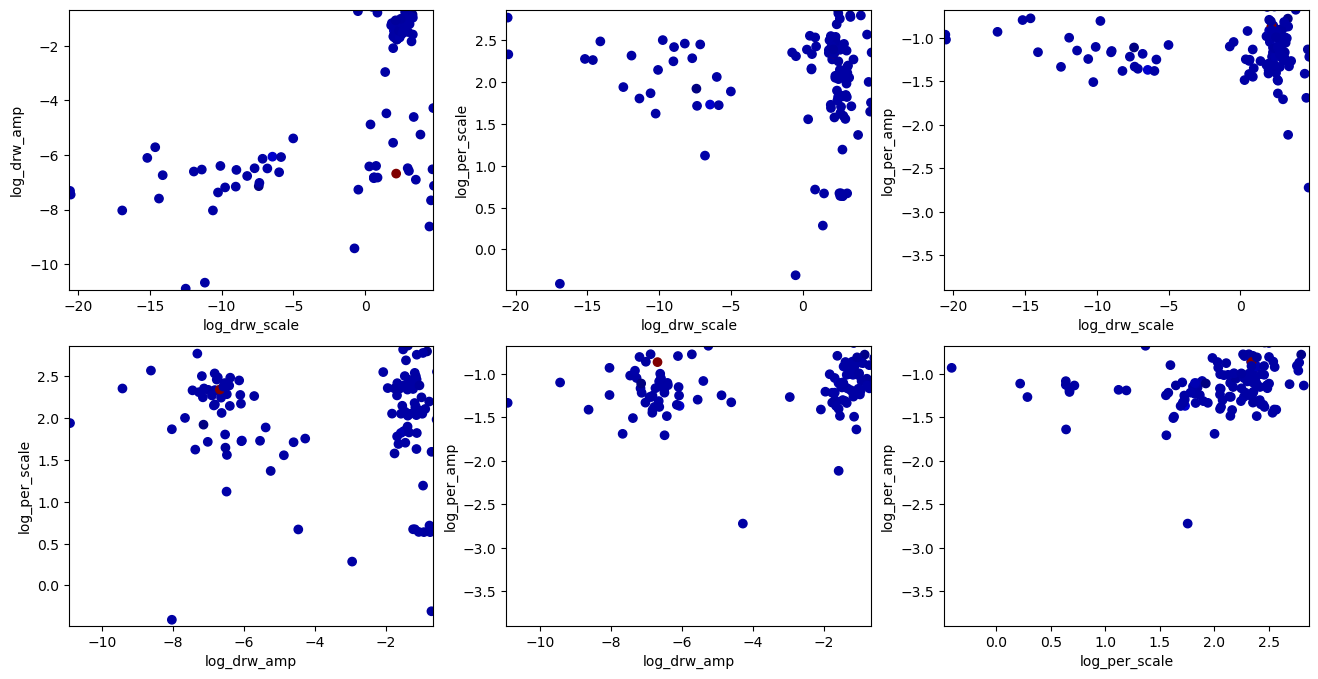

In [16]:
plot_likelihoods(res_tsp_run_0_np, res_tsp_run_0_drw_np)

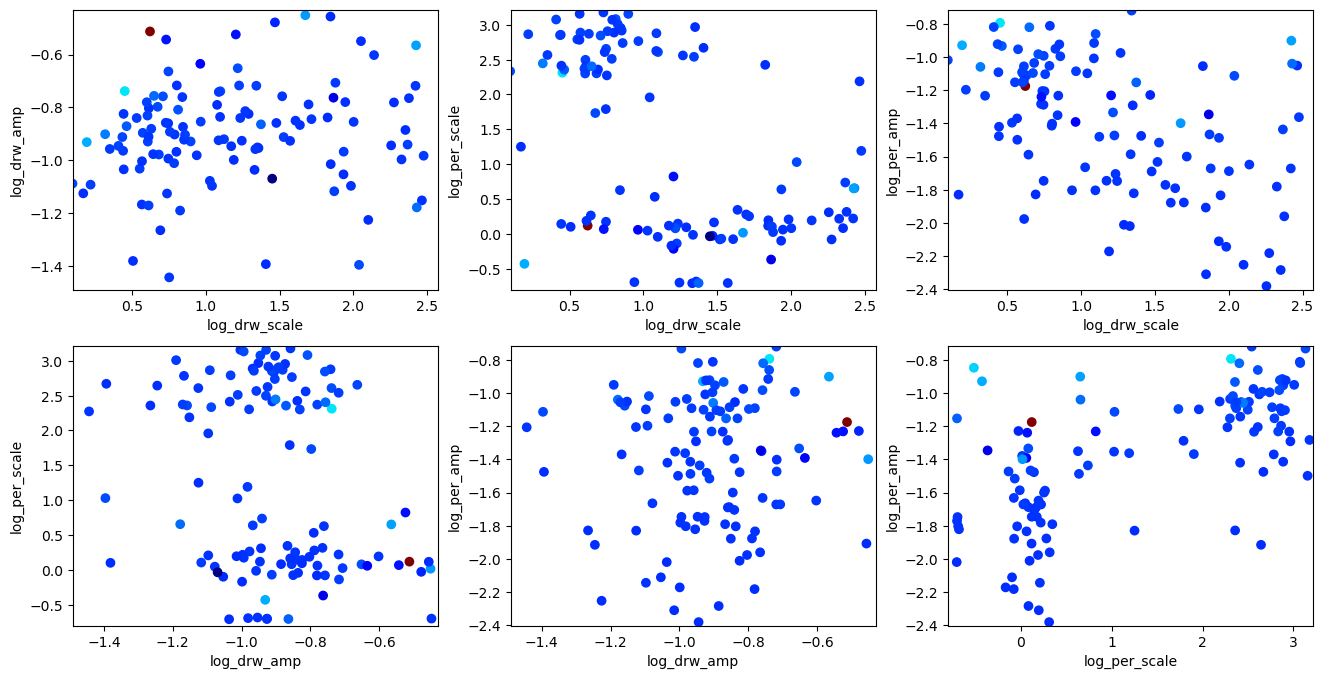

In [20]:
plot_likelihoods(celerite_run_np, celerite_run_drw_np)

In [23]:
def greatest_improvement(run, drw_run):
    # shows which one have greates absolute improvment
    df = pd.DataFrame(run['neg_log_lh']-drw_run['neg_log_lh'])
    df.sort_values(by='neg_log_lh', inplace=True)
    return df

In [24]:
greatest_improvement(res_tsp_run_0, res_tsp_run_0_drw)

,neg_log_lh
SDSS_NAME_dr16q_constant,
b'024455.18-002501.5',-7.522515e+00
b'023922.87-000119.6',-7.513662e+00
b'024220.73-002059.7',-5.444676e+00
b'023945.93-001220.0',-5.172377e+00
b'024104.28+000821.3',-4.930120e+00
...,...
b'024425.39-004653.0',-1.085092e-06
b'024400.19-003637.9',-9.867513e-07
b'024332.13+002733.4',-9.947598e-14


In [25]:
greatest_improvement(celerite_run, celerite_run_drw)

,neg_log_lh
SDSS_NAME_dr16q_constant,
b'024104.28+000821.3',-2.450038e+01
b'024514.00-003535.4',-2.148585e+01
b'024338.46+004433.6',-1.599498e+01
b'024106.85+001026.8',-1.339031e+01
b'024340.11-001749.4',-1.288657e+01
...,...
b'024400.19-003637.9',-4.959299e-03
b'024448.90+002858.6',-3.878412e-03
b'024442.77-004223.2',4.368725e-07
